# An effective theory of collective deep learning

Lluís Arola Fernández and Lucas Lacasa

Last modification: October 13, 2023 

-------------

## Local simulations and data visualization scripts. A toy example. 


### 1. Import libraries 

First, we import packages, load data and set hyperparameters 

Structure of the code 
Bla bla bla

In [9]:
### Imports
import torch
import torch.nn as nn                               # to access build-in functions to build the NN
import torch.nn.functional as F                     # to access activation functions
from torchvision import datasets, transforms        # to access the MNIST dataset
import torch.optim as optim                         # to build out optimizer
import numpy as np
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
import seaborn as sns
import sklearn.metrics
import networkx as nx
from sklearn.decomposition import PCA
from IPython.display import clear_output
import time
from numpy import savetxt
import copy
import itertools


### 2. Define classes and functions

- Neural network model (generic class) 

- Individual learning step (using data loader) 

- Collective learning step 
      
#### Neural network and supranetwork model

This class does not need parameters as inputs. The instance model reads parameters from the main (global variables?) 

Note that there are (num_layers+1) hidden layers of num_neurons each one 

In [10]:
class NNmodel(nn.Module):
         
    def __init__(self, input_size, output_size, num_layers, num_neurons):
        super(NNmodel, self).__init__()   

        if num_layers == 0:
            self.layers = nn.Sequential(
                nn.Linear(input_size, output_size)
            )
        else:
            modules = []
            modules.append(nn.Linear(input_size, num_neurons))
            for _ in range(num_layers - 1):
                modules.append(nn.ReLU())
                modules.append(nn.Linear(num_neurons, num_neurons))
            modules.append(nn.ReLU())
            modules.append(nn.Linear(num_neurons, output_size))
            self.layers = nn.Sequential(*modules)
        
    def forward(self, image, prints=False): 
        if prints: print('Image shape:', image.shape)
        image = image.view(-1, input_size)
        if prints: print('Image reshaped:', image.shape)
        out = self.layers(image)             
        if prints: print('Out shape:', out.shape)
        return out
    
def ER_network(N,p):
    G = nx.erdos_renyi_graph(N,p,seed=None,directed=False)
    A = nx.to_numpy_matrix(G)
    return A

def SG_network(N): 
    G = nx.star_graph(N-1)
    A = nx.to_numpy_matrix(G)
    return A
    
def WS_network(N,k,p):
    G = nx.watts_strogatz_graph(N,k,p)
    A = nx.to_numpy_matrix(G)
    return A


#### Functions to track weights during learning

In [11]:
def L2norm_weights(ensemble):
    l2_norms = []
    for model in ensemble:
        # Calculate the L2 norm of the model parameters
        l2_norm = torch.norm(torch.cat([p.flatten() for p in model.parameters() if p.requires_grad], dim=0), p=2)
        l2_norms.append(l2_norm)
    # Return the mean L2 norm across all models
    return torch.mean(torch.tensor(l2_norms))

def w2_weights(ensemble):
    l2_norms = []
    for model in ensemble:
        # Calculate the L2 norm of the model parameters
        l2_norm = torch.norm(torch.cat([p.flatten() for p in model.parameters() if p.requires_grad], dim=0), p=2)
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        l2_norms.append((l2_norm**2)/num_params)
    # Return the mean L2 norm across all models
    result = torch.mean(torch.tensor(l2_norms))
    
    return result.detach().numpy()

def distance_weights(ensemble):
    distances = []
    for i, model1 in enumerate(ensemble):
        for model2 in ensemble[i+1:]:
            # Calculate the L2 norm of the difference between the model parameters
            distance = torch.norm(torch.cat([p1.flatten() - p2.flatten() for p1, p2 in zip(model1.parameters(), model2.parameters()) if p1.requires_grad], dim=0), p=2)
            distances.append(distance)
    # Return the mean distance across all pairs of models
    result = torch.mean(torch.tensor(distances))
    return result.detach().numpy()

def mean_weights_model(model):
    # Calculate the mean of the model parameters
    mean = torch.mean(torch.cat([p.flatten() for p in model.parameters() if p.requires_grad], dim=0))
    return mean.detach().numpy()

def mean_weights(ensemble):
    means = []
    for model in ensemble:
        mean = mean_weights_model(model)
        means.append(mean)
    # Return a list with the mean of the models 
    #return torch.mean(torch.tensor(means))
    return(means)

def measure_PCA(ensemble): 
    # Concatenate the model parameters into a single tensor
    params = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad], dim=0)
    # Convert the tensor to a NumPy array
    params_np = params.detach().numpy()
    # Perform PCA using the sklearn.decomposition.PCA class
    pca = PCA(n_components=2)
    # return PCA decomposition of the ensemble 
    return(pca.fit_transform(params_np))
    
def plot_PCA(reduction):
    # Visualize the results using Matplotlib
    clear_output(wait=True)
    plt.figure()
    plt.figure(figsize=(5,5))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title("PCA (2D) of ensemble weights",fontsize=20)
    for k in range(num_models):
        plt.scatter(reduction[k][0], reduction[k][1])
    plt.xlim((-0.1, 0.1))   # set the xlim to left, right
    plt.ylim(-0.1, 0.1)     # set the xlim to left, right
    plt.show()
    plt.pause(0.000001)
    

#### Functions to evaluate learning process

In [12]:

# individual performance 
def evaluate_mean(model, test_data):
    
    # Sets the model in evaluation mode
    model.eval()
    
    # Creates the dataloader
    data_loader = torch.utils.data.DataLoader(test_data)
    criterion = nn.CrossEntropyLoss()
    
    correct_cases = 0
    total_cases = 0
    total_loss = 0.0  # to keep track of the total loss
    
    with torch.no_grad():  # disable gradient computation as we are in evaluation mode
        for (images, labels) in iter(data_loader):
            out = model(images)
            # Choose maximum probability and then select only the label (not the prob number)
            prediction = out.max(dim = 1)[1]

            # First check how many are correct in the batch, then we sum then convert to integer (not tensor)
            correct_cases += (prediction == labels).sum().item()
            # Total cases
            total_cases += images.shape[0]
            # Compute loss
            loss = criterion(out, labels)
            # Update total loss
            total_loss += loss.item()

            # Return accuracy and loss of the neural unit 
    return correct_cases/total_cases, total_loss / len(data_loader)   


# majority rule in the ensemble 
def evaluate_majority(ensemble,test_data):
    
    # Sets the model in evaluation mode
    #model.eval()
    # Creates the dataloader
    data_loader = torch.utils.data.DataLoader(test_data)
    correct_cases = 0
    total_cases = 0
    
    for (images, labels) in iter(data_loader):
        out = torch.zeros(1,10)
        for k in range(len(ensemble)):
            model = ensemble[k]
            model.eval()
            out = out + model(images)
            #print(out)
        # Choose maximum probability and then select only the label (not the prob number)
        prediction = out.max(dim = 1)[1]
        # First check how many are correct in the batch, then we sum then convert to integer (not tensor)
        correct_cases += (prediction == labels).sum().item()
        # Total cases
        total_cases += images.shape[0]

    return correct_cases/total_cases 


def compute_crossaccuracy_matrix(ensemble, mnist_test):
    
    num_models = len(ensemble)
    num_classes = 10 
    models_x_class = num_models // num_classes 

    crossaccuracy_matrix = np.zeros((num_models, num_models))
    crossaccuracy_cases = np.zeros((num_models, num_models))
    
    for data, target in mnist_test:
        # Get the predicted labels for each model
        predicted_labels = [model(data.unsqueeze(0)).argmax().item() for model in ensemble]

        # Get the true label as an integer
        true_label = int(target)

        # Update
        for i in range(num_models):
            for j in range (models_x_class):
                crossaccuracy_matrix[i, models_x_class*true_label+j] += (predicted_labels[i] == true_label)
                crossaccuracy_cases[i,models_x_class*true_label+j] += 1 
            
            
    # Normalize 
    crossaccuracy_matrix_normalized = np.divide(crossaccuracy_matrix,crossaccuracy_cases) 
    
    return crossaccuracy_matrix_normalized



### Learning step

Inputs: model instances, train_data, and scalar parameters 

Apply one step of the individual learning (learning a batch from data) 

In [13]:
def training_phase(ensemble, train_datasets, batch_size, tau, sigma, gamma):

    # define the loss function (e.g. cross entropy for classification tasks) 
    criterion = nn.CrossEntropyLoss()

    # initialize a counter to track model private data 
    idx = 0
    
    # count number of models and number of parameters in each model 
    num_models = len(ensemble)
    num_params = sum(p.numel() for p in ensemble[0].parameters() if p.requires_grad)
    
    # flatten all the weights of all the models in list of arrays
    weights0 = [torch.cat([param.detach().flatten() for param in model.parameters() if param.requires_grad]) for model in ensemble]
    
    # apply individual learning dynamics for each model in the ensemble (with private data)
    for model in ensemble:
        
        optimizer = optim.SGD(model.parameters(), lr=tau, momentum=0, weight_decay=gamma)
        model.zero_grad()
        train_loader = torch.utils.data.DataLoader(dataset=train_datasets[idx], batch_size=batch_size, shuffle=True)
        model.train()
        
        # Assuming there is only one batch in train_loader (the function receives a batch as a parameter)
        images, labels = next(iter(train_loader))
        out = model.forward(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        idx += 1
    
    if (sigma > 0): 
        # get the weights after the individual training step 
        weights1 = [torch.cat([param.detach().flatten() for param in model.parameters() if param.requires_grad]) for model in ensemble]

    
        # apply the collective learning step (euler-like method: diffusion is computed at the beginning of the step)
        for i in range(num_models):
            for j in range(num_models):
                weights1[i] += tau * sigma * (weights0[j] - weights0[i])
    
        # copy the updated parameters back into the model architecture 
        for i, model in enumerate(ensemble):
            aux = 0
            for param in model.parameters():
                if param.requires_grad:
                    num_param_elements = param.numel()
                    new_weights = weights1[i][aux:aux + num_param_elements].reshape(param.shape)
                    with torch.no_grad():
                        param.copy_(new_weights)
                    aux += num_param_elements
                
    
def create_filename(base_name, train_batch, tau, gamma, num_neurons, num_steps, num_sigma, adiabatic):
    tau_str = str(int(tau*100)).zfill(3)  # 3-digit string with leading zeros
    gamma_str = str(int(gamma*100)).zfill(3)  # 3-digit string with leading zeros
    filename = f'{base_name}_batch{train_batch}_tau{tau_str}_gamma{gamma_str}_neurons{num_neurons}_steps{num_steps}_sigma{num_sigma}_adiabatic{adiabatic}.csv'
    return filename     
                    


## EXPERIMENT ON MNIST DATASET

In [16]:
# Download and load the MNIST dataset
mnist_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
# Get the targets (labels) for the train and test data samples
mnist_targets = mnist_train.targets

#torch.manual_seed(1) # set the random seed
#np.random.seed(1) #set random seed in numpy
start_time = time.time()

# main parametrization 
input_size = 28*28
output_size = 10
num_models = 10

test_batch = 50
train_batch = 32
momentum = 0.0
resolution = 20 
tau = 0.005
gamma = 0.001
adiabatic = 1
num_steps = 5000
num_neurons = 20
vec_layers = [0,1,2]
vec_sigma0 = np.logspace(-4,1,25)
vec_sigma1 = np.linspace(10,390,26)
vec_sigma = np.concatenate((vec_sigma0,vec_sigma1[1:]))
num_sigma = len(vec_sigma)
num_classes = 10 
num_metrics = 2 

# initialize variables 
mnist_local = []
mnist_test = list(mnist_test)
rng = np.random.randint(0,10000-test_batch)
mnist_test_short = mnist_test[rng:rng+test_batch] 
mnist_test_short = list(mnist_test_short)
models_per_class = num_models // num_classes  # This will be 5
for k in range(num_models):
    target_class = k // models_per_class
    mnist_aux = [data for data, target in zip(mnist_train, mnist_targets) if target == target_class]
    mnist_local.append(mnist_aux)


states = np.zeros((num_models,num_sigma,len(vec_layers)))
magnetization = np.zeros((num_sigma,len(vec_layers)))
norm = np.zeros((num_sigma,len(vec_layers)))
accuracy_train = np.zeros((num_sigma,len(vec_layers)))
accuracy_test = np.zeros((num_sigma,len(vec_layers)))
loss_train = np.zeros((num_sigma,len(vec_layers)))
loss_test = np.zeros((num_sigma,len(vec_layers)))
couplings = np.zeros((num_sigma))
distance = np.zeros((num_sigma,len(vec_layers)))
crossaccuracy_matrices = []

for d in range(len(vec_layers)):

    num_layers = vec_layers[d]
        
    ensemble = []
    for k in range(num_models): 
        ensemble.append(NNmodel(input_size, output_size, num_layers, num_neurons))
        
    for s in range(num_sigma):
            
        if (adiabatic == 0):
            ensemble = []
            for k in range(num_models): 
                ensemble.append(NNmodel(input_size, output_size, num_layers, num_neurons))
                    
        sigma = vec_sigma[s]
            
        for t in range(num_steps):
            # Prepare all training datasets
            train_datasets = []
            for k in range(num_models):
                rng1 = np.random.randint(0,int(len(mnist_local[k])-train_batch)) 
                rng2 = rng1+train_batch 
                train_datasets.append(mnist_local[k][rng1:rng2])
                    
            # Call the training phase on all datasets at once
            training_phase(ensemble, train_datasets, train_batch, tau, sigma/num_models, gamma)
    
    
        metrics_train_sum1 = np.zeros((num_metrics))
        metrics_test_sum1 = np.zeros((num_metrics))
        num_steps_eval = 0 
        magnetization_sum1 = 0
        norm_sum1 = 0 
                
        for t in range(num_steps):
                
            metrics_train_sum = np.zeros((num_metrics))
            metrics_test_sum = np.zeros((num_metrics))
                
            #accuracy_train_sum = 0
            #accuracy_test_sum = 0
            magnetization_sum = 0
                
            if (t % resolution == 0):

                mnist_train_short = []
                
                for k in range(num_models):
                
                    mnist_train_short = mnist_local[k]
                    rng1 = np.random.randint(0,int(len(mnist_local[k])-train_batch)) 
                    rng2 = rng1+train_batch 
                    metrics_test_sum += evaluate_mean(ensemble[k],mnist_test_short)
                    metrics_train_sum += evaluate_mean(ensemble[k],mnist_train_short[rng1:rng2])
                
                
                magnetization_sum1 += np.mean(mean_weights(ensemble))
                norm_sum1 += np.mean(w2_weights(ensemble))
                metrics_train_sum1 += metrics_train_sum/num_models  
                metrics_test_sum1 += metrics_test_sum/num_models 
                num_steps_eval +=1 
                
            # Prepare all training datasets
            train_datasets = []
            for k in range(num_models):
                rng1 = np.random.randint(0,int(len(mnist_local[k])-train_batch)) 
                rng2 = rng1+train_batch 
                train_datasets.append(mnist_local[k][rng1:rng2])
        
            # Call the training phase on all datasets at once
            training_phase(ensemble, train_datasets, train_batch, tau, sigma/num_models, gamma)
              
        crossaccuracy_matrix = np.zeros((num_models,num_models)) 
        crossaccuracy_matrix = compute_crossaccuracy_matrix(ensemble,mnist_test)
        crossaccuracy_matrices.append(crossaccuracy_matrix)
                
        
        states[:,s,d] = mean_weights(ensemble)
        distance[s,d] = distance_weights(ensemble)
        magnetization[s,d] = magnetization_sum1/num_steps_eval
        norm[s,d] = norm_sum1/num_steps_eval
        accuracy_train[s,d] = metrics_train_sum1[0]/num_steps_eval
        accuracy_test[s,d] = metrics_test_sum1[0]/num_steps_eval
        loss_train[s,d] = metrics_train_sum1[1] /num_steps_eval
        loss_test[s,d] = metrics_test_sum1[1]/num_steps_eval
        
        #print(states[:,s,d])
            
        print(d,s,accuracy_test[s][d])



0 0 0.10000000000000035
0 1 0.10000000000000035
0 2 0.10000000000000035
0 3 0.10000000000000035
0 4 0.10000000000000035
0 5 0.10000000000000035
0 6 0.10000000000000035
0 7 0.10000000000000035
0 8 0.10000000000000035
0 9 0.10000000000000035
0 10 0.10000000000000035
0 11 0.10000000000000035
0 12 0.10000000000000035
0 13 0.10818399999999949
0 14 0.13135200000000058
0 15 0.18352000000000018
0 16 0.30903199999999953
0 17 0.46695200000000003
0 18 0.6479519999999995
0 19 0.7737760000000001
0 20 0.853272000000002
0 21 0.8902719999999957
0 22 0.9150400000000005
0 23 0.9316959999999983
0 24 0.9379519999999953
0 25 0.9405919999999989
0 26 0.9409440000000002
0 27 0.9400159999999983
0 28 0.9399999999999982
0 29 0.9399999999999982
0 30 0.9399999999999982
0 31 0.9399999999999982
0 32 0.9399999999999982
0 33 0.9399999999999982
0 34 0.9399999999999982
0 35 0.9399999999999982
0 36 0.9399999999999982
0 37 0.9399999999999982
0 38 0.9399999999999982
0 39 0.9399999999999982
0 40 0.9399999999999982
0 41 0.93

## SAVE DATA

In [387]:
import pandas as pd

# Save each array as a separate CSV file
#pd.DataFrame(states).to_csv('states.csv', index=False)
pd.DataFrame(magnetization).to_csv('magnetization.csv', index=False)
pd.DataFrame(norm).to_csv('norm.csv', index=False)
pd.DataFrame(accuracy_train).to_csv('accuracy_train.csv', index=False)
pd.DataFrame(accuracy_test).to_csv('accuracy_test.csv', index=False)
pd.DataFrame(loss_train).to_csv('loss_train.csv', index=False)
pd.DataFrame(loss_test).to_csv('loss_test.csv', index=False)
pd.DataFrame(couplings).to_csv('couplings.csv', index=False)
#pd.DataFrame(distance).to_csv('distance.csv', index=False)
# For crossaccuracy_matrices, since it's a list of arrays, you can save each array as a separate CSV
for idx, matrix in enumerate(crossaccuracy_matrices):
    pd.DataFrame(matrix).to_csv(f'crossaccuracy_matrix_{idx}.csv', index=False)


### EVOLUTION OF CROSS-ACCURACY MATRICES

depth:  0


/var/folders/c5/kk81kmh50gn9bq1kf4_4mqhm0000gn/T/ipykernel_76721/2609054485.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10,10, s + 1)  # Adjust the subplot layout according to your preferences


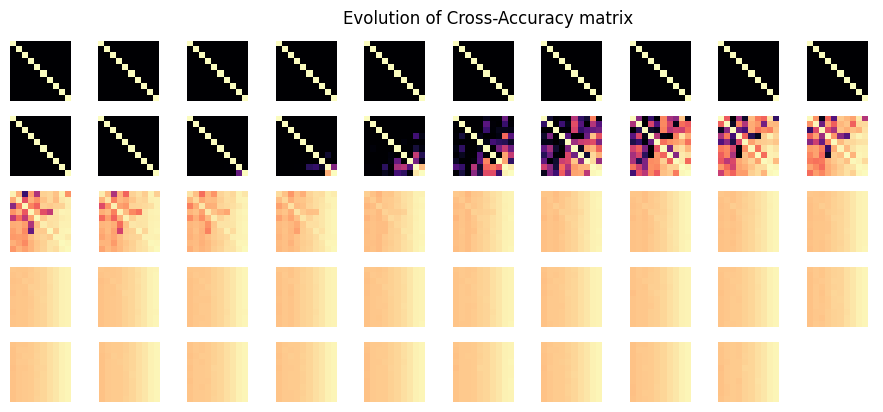

depth:  1


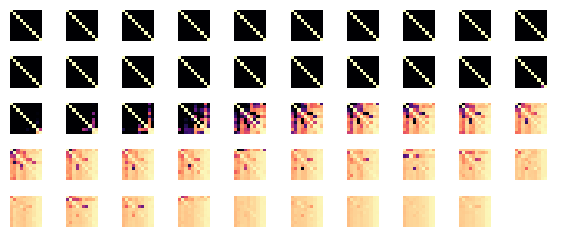

depth:  2


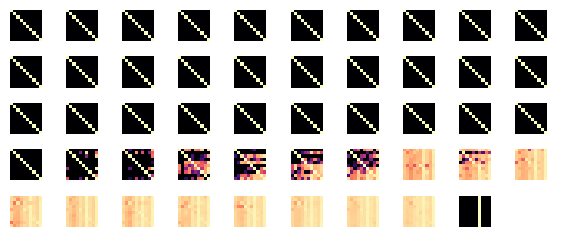

In [564]:
import numpy as np
import matplotlib.pyplot as plt

#print(confusion_matrices)
# Assuming you have your confusion_matrices list already computed

num_sigma = len(vec_sigma)

# Find the maximum value across all confusion matrices
max_value = np.max([np.max(cm) for cm in crossaccuracy_matrices])

# Visualize the evolution of confusion matrices
plt.figure(figsize=(10, 8))
plt.suptitle("Evolution of Cross-Accuracy matrix")



for d in range (len(vec_layers)):
    print('depth: ',d)
    for s in range(num_sigma):
        
        
        order = np.argsort(np.mean(crossaccuracy_matrices[45*(d+1)],axis=0))
        reordered_matrix = crossaccuracy_matrices[d*num_sigma+s][order][:, order]
        plt.imshow(reordered_matrix, cmap="magma", vmin=0, vmax=max_value)
        plt.subplot(10,10, s + 1)  # Adjust the subplot layout according to your preferences
        #plt.imshow((crossaccuracy_matrices[d*num_sigma+s]), cmap="magma", vmin=0, vmax=max_value)
        plt.axis('off')
    #plt.title(f"Coupling: {vec_sigma[s]:.2f}")
    #plt.xlabel("Predicted Label")
    #plt.ylabel("True Label")

    # Add a common colorbar
    #cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Adjust position as needed
    #plt.colorbar(cax=cax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the colorbar
    plt.show()


#print(crossaccuracy_matrices[52])
#print(np.mean(crossaccuracy_matrices[40],1))
#disorder = np.mean(crossaccuracy_matrices[45],axis=0)
#disorder = disorder - np.mean(disorder)
#plt.hist(disorder,20)
#print(disorder)


[0 1 2 3 4 5 6 7 8 9]
[8 5 2 9 3 7 4 6 1 0]
[5 2 8 9 3 7 4 6 1 0]


/var/folders/c5/kk81kmh50gn9bq1kf4_4mqhm0000gn/T/ipykernel_76721/1583320097.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Adjust layout to accommodate the colorbars


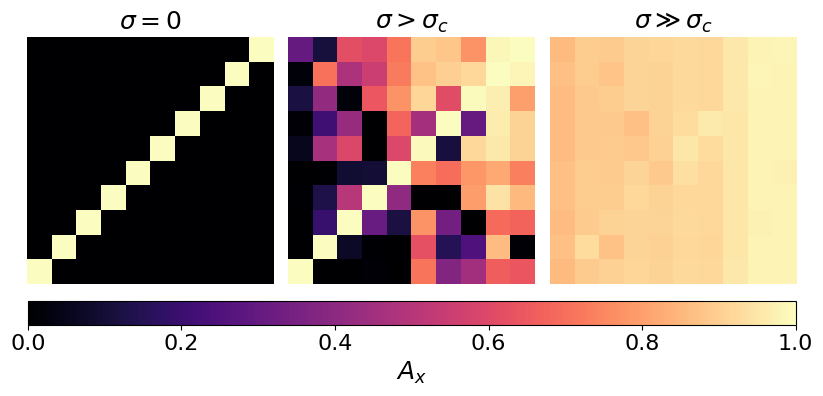

In [553]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have your crossaccuracy_matrices list already computed

# Indices of the three specific sigma values you want to plot
sigma_indices = [0,25,45]  # Replace with the actual indices

#order = np.argsort(np.mean(crossaccuracy_matrices[49], axis=0))
#print(order)

# Depth you want to plot
depth = 1  # Replace with the desired depth

# Find the maximum value across all confusion matrices
max_value = 1 #np.max([np.max(cm) for cm in crossaccuracy_matrices])

# Visualize the matrices for the specific sigma values and depth
plt.figure(figsize=(8, 8))
#plt.suptitle("Cross-Accuracy matrix for specific sigma values")

mappables = []  # List to store the mappable objects

for i, sigma_index in enumerate(sigma_indices):
    # First row: Without sorting
    ax1 = plt.subplot(1, 3, i + 1)
    order = np.argsort(np.mean(crossaccuracy_matrices[sigma_index], axis=0))
    print(order)
    reordered_matrix = crossaccuracy_matrices[depth*num_sigma + sigma_index][order][:, order]
    mappable = ax1.imshow(reordered_matrix, cmap="magma", vmin=0, vmax=max_value)
    mappables.append(mappable)
    if i== 0: 
        ax1.set_title('$\sigma = 0$',fontsize=18)
    if i == 1:
        ax1.set_title('$\sigma > \sigma_c$',fontsize=18)
    if i ==2: 
        ax1.set_title('$\sigma \gg \sigma_c$',fontsize=18)
        
    #ax1.set_title(f"Coupling: {vec_sigma[sigma_index]:.2f}")
    ax1.invert_yaxis()  # Invert the x-axis
    ax1.axis('off')

# Add a common colorbar below the figures
cax1 = plt.axes([0.02, 0.37, 0.96, 0.03])  # Adjust position as needed
cbar = plt.colorbar(mappable=mappables[-1], cax=cax1, orientation='horizontal')
cbar.set_label('$A_x$', size=18)  # Set label size
cbar.ax.tick_params(labelsize=16)  # Set tick label size

plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Adjust layout to accommodate the colorbars
plt.show()


[0 1 2 3 4 5 6 7 8 9]
[8 5 3 2 9 6 4 7 0 1]
[5 8 2 9 3 7 6 4 1 0]


/var/folders/c5/kk81kmh50gn9bq1kf4_4mqhm0000gn/T/ipykernel_76721/2456858638.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Adjust layout to accommodate the colorbars


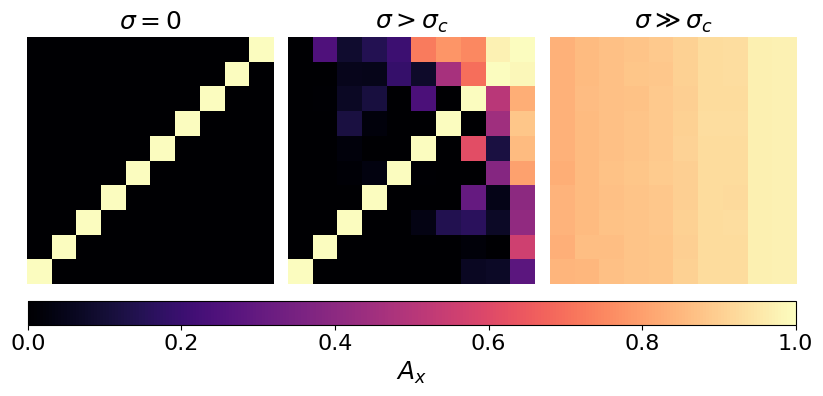

In [591]:
import pandas as pd
import numpy as np

folder = '/Users/lluisarolafernandez/desktop/COLLECTIVE_FIGS/data_collective_19_10_23'

# Number of matrices and runs
num_matrices = 50
num_runs = 10

crossaccuracy_matrices = []
crossaccuracy_matrices1 = []
crossaccuracy_matrices2 = []

# Loop over each matrix index
for i in range(num_matrices):
    # Initialize an empty list to store matrices for each run
    matrices_for_current_index = []
    matrices_for_current_index1 = []
    matrices_for_current_index2 = []
    
    # Loop over each run
    for run in range(1, num_runs + 1):
        # Construct the file name
        filename = f"{folder}/crossaccuracy_matrix_{i}_gamma_0.001_depth_0_run_{run}_notadiabatic.csv"
        filename1 = f"{folder}/crossaccuracy_matrix_{i}_gamma_0.001_depth_1_run_{run}_notadiabatic.csv"
        filename2 = f"{folder}/crossaccuracy_matrix_{i}_gamma_0.001_depth_2_run_{run}_notadiabatic.csv"
        
        # Load the matrix from the CSV file
        matrix = pd.read_csv(filename).values
        matrix1 = pd.read_csv(filename1).values
        matrix2 = pd.read_csv(filename2).values
        
        # Append the matrix to the list
        matrices_for_current_index.append(matrix)
        matrices_for_current_index1.append(matrix1)
        matrices_for_current_index2.append(matrix2)
    
    # Average the matrices over the runs and append to the main list
    averaged_matrix = np.mean(matrices_for_current_index, axis=0)
    crossaccuracy_matrices.append(averaged_matrix)
    
    averaged_matrix1 = np.mean(matrices_for_current_index1, axis=0)
    crossaccuracy_matrices1.append(averaged_matrix1)
    
    averaged_matrix2 = np.mean(matrices_for_current_index2, axis=0)
    crossaccuracy_matrices2.append(averaged_matrix2)
    
    


# Assuming you have your crossaccuracy_matrices list already computed

# Indices of the three specific sigma values you want to plot
sigma_indices = [0,24,48]  # Replace with the actual indices

#order = np.argsort(np.mean(crossaccuracy_matrices[49], axis=0))
#print(order)

# Depth you want to plot
depth = 1  # Replace with the desired depth

# Find the maximum value across all confusion matrices
max_value = 1 #np.max([np.max(cm) for cm in crossaccuracy_matrices])

# Visualize the matrices for the specific sigma values and depth
plt.figure(figsize=(8, 8))
#plt.suptitle("Cross-Accuracy matrix for specific sigma values")

mappables = []  # List to store the mappable objects

for i, sigma_index in enumerate(sigma_indices):
    # First row: Without sorting
    ax1 = plt.subplot(1, 3, i + 1)
    order = np.argsort(np.mean(crossaccuracy_matrices1[sigma_index], axis=0))
    print(order)
    reordered_matrix = crossaccuracy_matrices1[sigma_index][order][:, order]
    mappable = ax1.imshow(reordered_matrix, cmap="magma", vmin=0, vmax=max_value)
    mappables.append(mappable)
    if i== 0: 
        ax1.set_title('$\sigma = 0$',fontsize=18)
    if i == 1:
        ax1.set_title('$\sigma > \sigma_c$',fontsize=18)
    if i ==2: 
        ax1.set_title('$\sigma \gg \sigma_c$',fontsize=18)
        
    #ax1.set_title(f"Coupling: {vec_sigma[sigma_index]:.2f}")
    ax1.invert_yaxis()  # Invert the x-axis
    ax1.axis('off')

# Add a common colorbar below the figures
cax1 = plt.axes([0.02, 0.37, 0.96, 0.03])  # Adjust position as needed
cbar = plt.colorbar(mappable=mappables[-1], cax=cax1, orientation='horizontal')
cbar.set_label('$A_x$', size=18)  # Set label size
cbar.ax.tick_params(labelsize=16)  # Set tick label size

plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Adjust layout to accommodate the colorbars
plt.show()


### RANK ONE APPROXIMATION VALIDATION

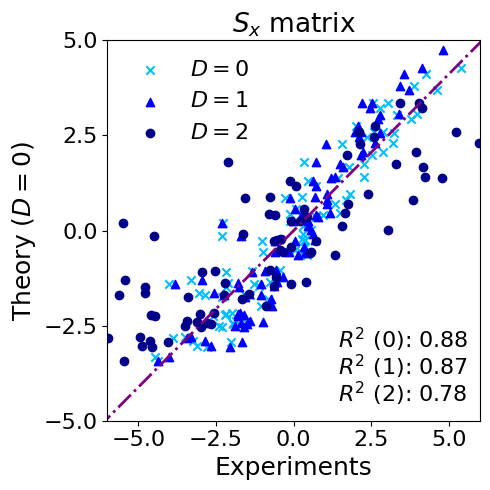

In [593]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sum_matrix = np.zeros((num_models,num_models))
sum_matrix1 = np.zeros((num_models,num_models))
sum_matrix2 = np.zeros((num_models,num_models))
for s in range(num_sigma):
    sum_matrix += crossaccuracy_matrices[s]
    sum_matrix1 += crossaccuracy_matrices1[s]
    sum_matrix2 += crossaccuracy_matrices2[s]

# SVD decomposition
U, S, Vt = np.linalg.svd(sum_matrix)

# Rank-one approximation
rank_one_approx = S[0] * np.outer(U[:, 0], Vt[0, :])

# Create indices for rows and columns excluding the diagonal
rows, cols = np.indices((num_models, num_models))
off_diag_indices = rows != cols

# Get the flattened array of off-diagonal elements
empirical_D0 = sum_matrix[off_diag_indices]
empirical_D1 = sum_matrix1[off_diag_indices]
empirical_D2 = sum_matrix2[off_diag_indices]
rankone_D0 = rank_one_approx[off_diag_indices]

# Create a new figure with a size that can accommodate both subplots
plt.figure(figsize=(5,5))

#plt.title("Validation (MNIST)", fontsize=15)
plt.xlabel("Experiments", fontsize=18)
plt.ylabel("Theory ($D=0$)", fontsize=18)

empirical_matrices = [empirical_D0, empirical_D1, empirical_D2]
colors = ['deepskyblue','blue', 'darkblue']
markers = ['x','^','o']
names = ['$D = 0$','$D=1$','$D=2$']

all_empirical = []  # To store all empirical data for the best fit line
correlation_coefficients = []  # To store R^2 values

# Plot the scatter plots in your desired order
for empirical, color, marker, name in zip(empirical_matrices, colors, markers, names):
    plt.scatter(empirical - np.mean(empirical), rankone_D0 - np.mean(rankone_D0),color=color, marker=marker, label=name)

    # Append empirical data for the best fit line
    all_empirical.extend(empirical)

    # Calculate and store the correlation coefficient
    correlation_matrix = np.corrcoef(empirical, rankone_D0)
    correlation_coefficients.append(correlation_matrix[0, 1] ** 2)

# Plot the best fit line using empirical_D0 data
coefficients = np.polyfit(empirical_D0 - np.mean(empirical_D0), rankone_D0 - np.mean(rankone_D0), 1)
polynomial = np.poly1d(coefficients)
x_vals = np.linspace(min(empirical_D0 - np.mean(empirical_D0))-10, 10+max(empirical_D0 - np.mean(empirical_D0)), 100)
plt.plot(x_vals, polynomial(x_vals),color='purple',linestyle='-.', linewidth=2)

# Display R^2 with larger font
fontsize_val = 16
plt.gca().text(0.62, 0.19, f"$R^2$ $(0)$: {correlation_coefficients[0]:.2f}", color='k', transform=plt.gca().transAxes, fontsize=fontsize_val)
plt.gca().text(0.62, 0.12, f"$R^2$ $(1)$: {correlation_coefficients[1]:.2f}", color='k', transform=plt.gca().transAxes, fontsize=fontsize_val)
plt.gca().text(0.62, 0.05, f"$R^2$ $(2)$: {correlation_coefficients[2]:.2f}", color='k', transform=plt.gca().transAxes, fontsize=fontsize_val)
x_ticks = [-5,-2.5,0,2.5,5]
y_ticks = [-5,-2.5,0,2.5,5]
plt.xticks(x_ticks,fontsize=16)
plt.yticks(y_ticks,fontsize=16)
plt.xlim(-6, 6)
plt.ylim(-5, 5)
plt.title('$S_x$ matrix',fontsize=19)
# Tight layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 1])
plt.legend(frameon=False, fontsize=16)

# Show the plots
plt.show()

### DEPTH-INDEPENDENT CUMULATIVE CROSS-ACCURACY

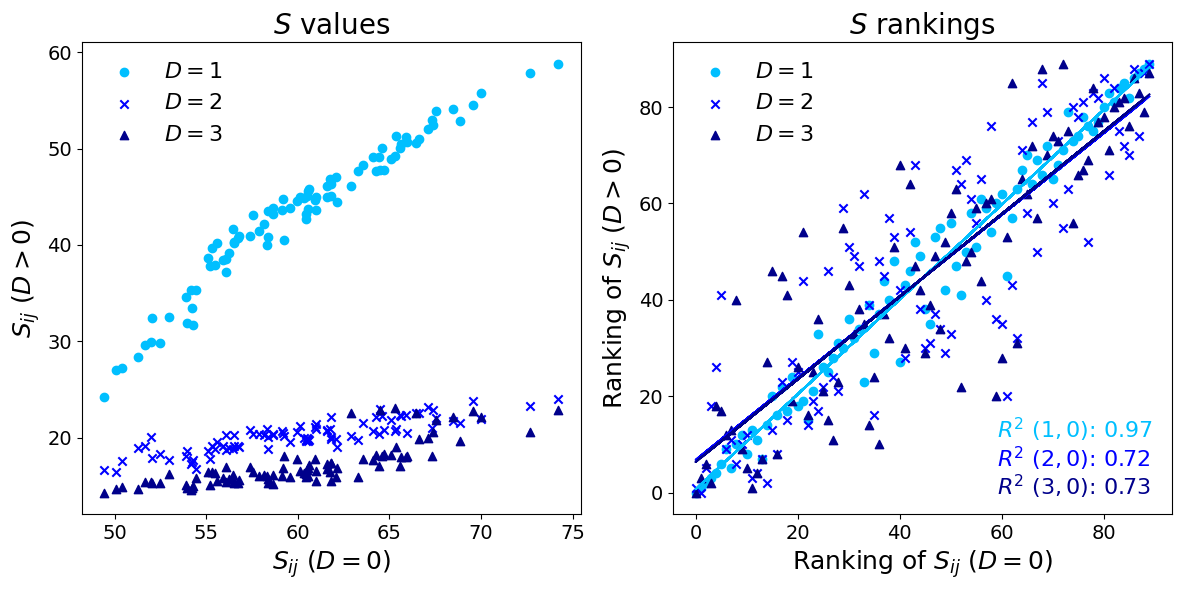

In [133]:
from scipy.stats import linregress

# Read matrices from the files
matrix_D0 = np.loadtxt('cumulative_cross_accuracy_D0.txt')
matrix_D1 = np.loadtxt('cumulative_cross_accuracy_D1.txt')
matrix_D2 = np.loadtxt('cumulative_cross_accuracy_D2.txt')
matrix_D3 = np.loadtxt('cumulative_cross_accuracy_D3.txt')

# Function to extract off-diagonal entries from a matrix
def get_off_diagonal(matrix):
    return matrix[np.where(~np.eye(matrix.shape[0], dtype=bool))]

# Extract off-diagonal entries
entries_D0 = (get_off_diagonal(matrix_D0))
entries_D1 = (get_off_diagonal(matrix_D1))
entries_D2 = (get_off_diagonal(matrix_D2))
entries_D3 = (get_off_diagonal(matrix_D3))

# Function to get rankings
def get_rankings(array):
    return array.argsort().argsort()

# Get the rankings
rankings_D0 = get_rankings(entries_D0)
rankings_D1 = get_rankings(entries_D1)
rankings_D2 = get_rankings(entries_D2)
rankings_D3 = get_rankings(entries_D3)

# Correlation coefficients for rankings
corr_coeff_rankings_D1 = np.corrcoef(rankings_D0, rankings_D1)[0, 1]
corr_coeff_rankings_D2 = np.corrcoef(rankings_D0, rankings_D2)[0, 1]
corr_coeff_rankings_D3 = np.corrcoef(rankings_D0, rankings_D3)[0, 1]

# R^2 values for rankings
R2_rankings_D1 = corr_coeff_rankings_D1**2
R2_rankings_D2 = corr_coeff_rankings_D2**2
R2_rankings_D3 = corr_coeff_rankings_D3**2

# Create a 1x2 grid for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot raw values on the left subplot
axes[0].scatter(entries_D0, entries_D1, c='deepskyblue', label='$D = 1$',marker='o')
axes[0].scatter(entries_D0, entries_D2, c='blue', label='$D = 2$',marker='x')
axes[0].scatter(entries_D0, entries_D3, c='darkblue', label='$D = 3$',marker='^')

# Plot rankings on the right subplot
axes[1].scatter(rankings_D0, rankings_D1, color='deepskyblue', label='$D = 1$',marker='o')
axes[1].scatter(rankings_D0, rankings_D2, color='blue', label='$D = 2$',marker='x')
axes[1].scatter(rankings_D0, rankings_D3, color='darkblue', label='$D = 3$',marker='^')



# ... [The previous code remains unchanged]

# Increase the font size in both subplots
axes[0].set_xlabel('$S_{ij}$ $(D = 0)$', fontsize=18)
axes[0].set_ylabel('$S_{ij}$ $(D > 0)$', fontsize=18)
axes[0].set_title('$S$ values', fontsize=20)
axes[1].set_xlabel('Ranking of $S_{ij}$ $(D = 0)$', fontsize=18)
axes[1].set_ylabel('Ranking of $S_{ij}$ $(D > 0)$', fontsize=18)
axes[1].set_title('$S$ rankings', fontsize=20)

# Plot regression lines for each dataset in the rankings subplot
for x, y, color in [(rankings_D0, rankings_D1, 'deepskyblue'), (rankings_D0, rankings_D2, 'blue'), (rankings_D0, rankings_D3, 'darkblue')]:
    slope, intercept, _, _, _ = linregress(x, y)
    axes[1].plot(x, slope * x + intercept, color=color, linestyle='-')

# Display R^2 with larger font
fontsize_val = 16
axes[1].text(0.65, 0.16, f"$R^2$ $(1,0)$: {R2_rankings_D1:.2}", color='deepskyblue', transform=axes[1].transAxes, fontsize=fontsize_val)
axes[1].text(0.65, 0.10, f"$R^2$ $(2,0)$: {R2_rankings_D2:.2f}", color='blue', transform=axes[1].transAxes, fontsize=fontsize_val)
axes[1].text(0.65, 0.04, f"$R^2$ $(3,0)$: {R2_rankings_D3:.2f}", color='darkblue', transform=axes[1].transAxes, fontsize=fontsize_val)


# Increase the font size for legends
legend_font_size = 16
axes[0].legend(frameon=False, fontsize=legend_font_size)
axes[1].legend(frameon=False, fontsize=legend_font_size)

# Increase the font size for the axis tick labels
tick_font_size = 14
axes[0].tick_params(axis='both', which='major', labelsize=tick_font_size)
axes[1].tick_params(axis='both', which='major', labelsize=tick_font_size)

plt.tight_layout()
plt.show()





### EFFECTIVE DIMENSION FROM DATA

[17.096653  16.077839  13.854652  13.950644  13.389159  12.1291895
 14.573564  14.25714   12.551945  12.871768 ]


/var/folders/c5/kk81kmh50gn9bq1kf4_4mqhm0000gn/T/ipykernel_70808/1401179557.py:102: RuntimeWarning: divide by zero encountered in log10
  cax = ax1.imshow(np.log10(matrix3), cmap="Reds")


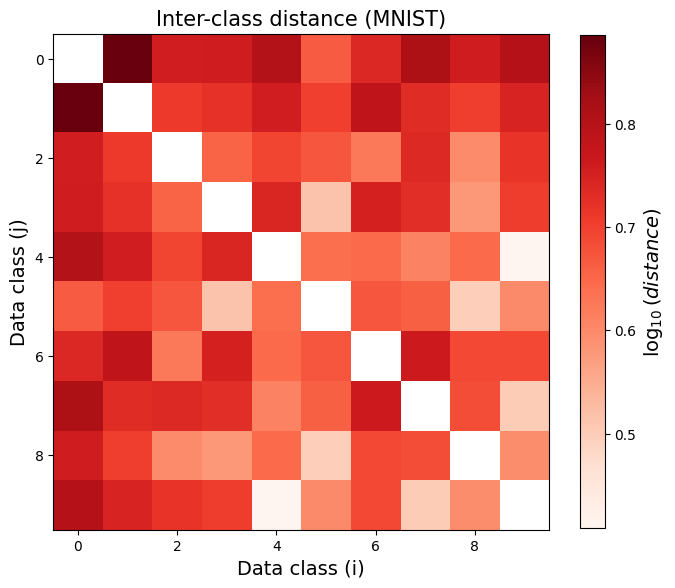

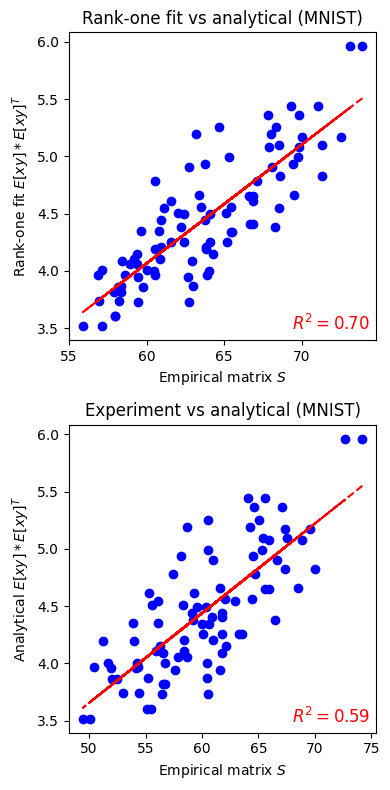

In [203]:

# Initialize a tensor to store the sum of images in each class
sum_images_per_class = torch.zeros(10, 28, 28)
# Initialize a tensor to store the count of images in each class
count_per_class = torch.zeros(10)
# Iterate over the MNIST train dataset to compute the sum of images and count of images for each class
for image, label in mnist_test:
    sum_images_per_class[label] += image[0]
    count_per_class[label] += 1

# Compute the mean image for each class
mean_images_per_class = sum_images_per_class / count_per_class.view(-1, 1, 1)

# Compute the similarity matrix between classes (10x10 matrix)
similarity_matrix = torch.zeros(10, 10)
for i in range(10):
    for j in range(10):
        distance = torch.norm(mean_images_per_class[i] - mean_images_per_class[j])
        similarity_matrix[i][j] = distance

# Compute the row-sum of the similarity matrix
row_sum_vector = torch.sum(similarity_matrix, dim=1)

distance_matrix = similarity_matrix.detach().numpy()

# Compute the intra-class variance
intra_class_variance = torch.zeros(10)
for i in range(10):
    sum_squared_diff = 0
    for image, label in mnist_test:
        if label == i:
            sum_squared_diff += torch.sum((image[0] - mean_images_per_class[i]) ** 2)
    intra_class_variance[i] = sum_squared_diff / count_per_class[i]


# Create indices for rows and columns excluding the diagonal
rows, cols = np.indices((num_models, num_models))
off_diag_indices = rows != cols


# SVD decomposition
U, S, Vt = np.linalg.svd(sum_matrix)

# Rank-one approximation
rank_one_approx = S[0] * np.outer(U[:, 0], Vt[0, :])

# Create indices for rows and columns excluding the diagonal
rows, cols = np.indices((num_models, num_models))
off_diag_indices = rows != cols

# Get the flattened array of off-diagonal elements
empirical = sum_matrix[off_diag_indices]
rankone_fit = rank_one_approx[off_diag_indices]





# SVD decomposition
U, S, Vt = np.linalg.svd(distance_matrix)

# Rank-one approximation
rank_one_approx = S[0] * np.outer(U[:, 0], Vt[0, :])

# Create indices for rows and columns excluding the diagonal
rows, cols = np.indices((num_models, num_models))
off_diag_indices = rows != cols

# Get the flattened array of off-diagonal elements
empirical = sum_matrix[off_diag_indices]
rankone = rank_one_approx[off_diag_indices]



vector1 = row_sum_vector.numpy()/np.sqrt(num_models)
#vector1 = vector1 - np.mean(vector1)
vector2 = intra_class_variance.numpy()

print(vector1)
matrix1 = np.outer(vector1,vector1)
matrix2 = np.outer(vector2,vector2)
matrix3 = similarity_matrix.numpy()

# Get the flattened array of off-diagonal elements
#theory1 = matrix1[off_diag_indices]
theory1 = rankone

theory2 = matrix2[off_diag_indices]
theory3 = matrix3[off_diag_indices]




for i in range(num_models):
    matrix3[i,i] = 0

# Create a new figure with a size that can accommodate both subplots
plt.figure(figsize=(8,8))

# First Subplot: "Accumulated inter-model matrix"
ax1 = plt.subplot(1,1,1)  # 2 rows, 2 columns, current subplot is 2
plt.title("Inter-class distance (MNIST)", fontsize=15)
cax = ax1.imshow(np.log10(matrix3), cmap="Reds")
plt.xlabel('Data class (i)', fontsize=14)
plt.ylabel('Data class (j)', fontsize=14)
cbar = plt.colorbar(cax, ax=ax1, shrink=0.8)  # Shrink the colorbar by 20%
cbar.set_label("$\log_{10}(distance)$", fontsize=14)  # Set the colorbar label


plt.figure(figsize=(4,8))


# Create a scatter plot
plt.subplot(2,1,1)
plt.scatter(rankone_fit, theory1, color='blue')

# Set the labels and title
plt.xlabel("Empirical matrix $S$")
plt.ylabel("Rank-one fit $E[xy]*E[xy]^T$")
plt.title("Rank-one fit vs analytical (MNIST)")



correlation_matrix = np.corrcoef(rankone_fit, theory1)
correlation_coefficient = correlation_matrix[0, 1]

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Place the text in the right-bottom corner
padding = 0.02  # You can adjust this padding as required
x_pos = xlim[1] - padding * (xlim[1] - xlim[0])
y_pos = ylim[0] + padding * (ylim[1] - ylim[0])

plt.text(x_pos, y_pos, '$R^2= {:.2f}$'.format(correlation_coefficient**2), color='red', fontsize=12, ha='right', va='bottom')
#plt.text(empirical[0], rankone[-1], 'c.c = {:.2f}'.format(correlation_coefficient), color='red', fontsize=12,position='rb')
# Plot the best fit line
coefficients = np.polyfit(rankone_fit, theory1, 1)
polynomial = np.poly1d(coefficients)
plt.plot(rankone_fit, polynomial(rankone_fit), 'r--')
#plt.text(empirical[0], rankone[-1], 'c.c = {:.2f}'.format(coefficients[0]),color='red', fontsize=12)

# Create a scatter plot
plt.subplot(2,1,2)
plt.scatter(empirical, theory1, color='blue')

# Set the labels and title
plt.xlabel("Empirical matrix $S$")
plt.ylabel("Analytical $E[xy]*E[xy]^T$")
plt.title("Experiment vs analytical (MNIST)")

correlation_matrix = np.corrcoef(empirical, theory1)
correlation_coefficient = correlation_matrix[0, 1]

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Place the text in the right-bottom corner
padding = 0.02  # You can adjust this padding as required
x_pos = xlim[1] - padding * (xlim[1] - xlim[0])
y_pos = ylim[0] + padding * (ylim[1] - ylim[0])

plt.text(x_pos, y_pos, '$R^2 = {:.2f}$'.format(correlation_coefficient**2), color='red', fontsize=12, ha='right', va='bottom')
#plt.text(empirical[0], rankone[-1], 'c.c = {:.2f}'.format(correlation_coefficient), color='red', fontsize=12,position='rb')
# Plot the best fit line
coefficients = np.polyfit(empirical, theory1, 1)
polynomial = np.poly1d(coefficients)
plt.plot(empirical, polynomial(empirical), 'r--')
#plt.text(empirical[0], rankone[-1], 'c.c = {:.2f}'.format(coefficients[0]),color='red', fontsize=12)



plt.tight_layout()  # Ensures that subplots don't overlap
plt.show()











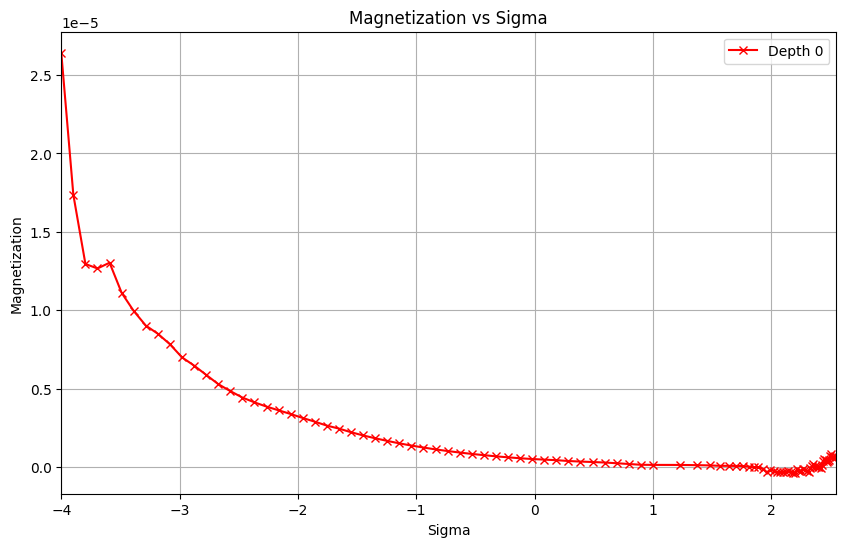

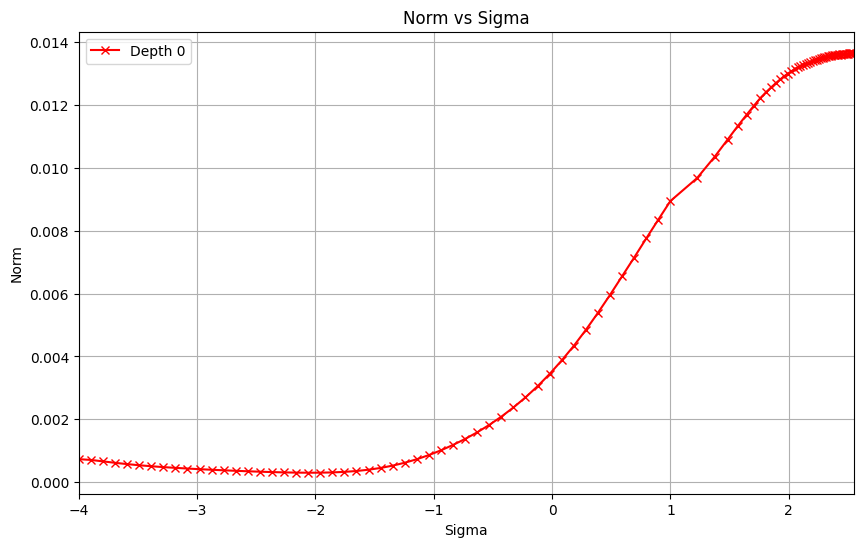

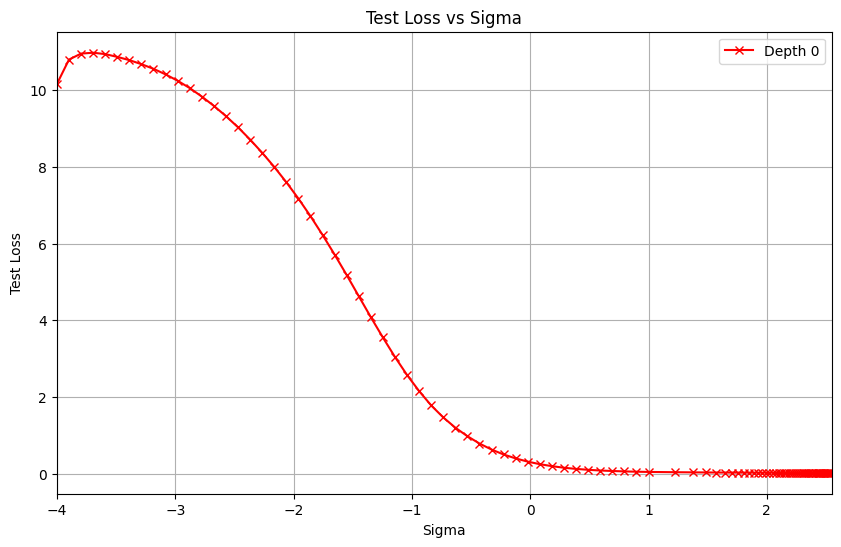

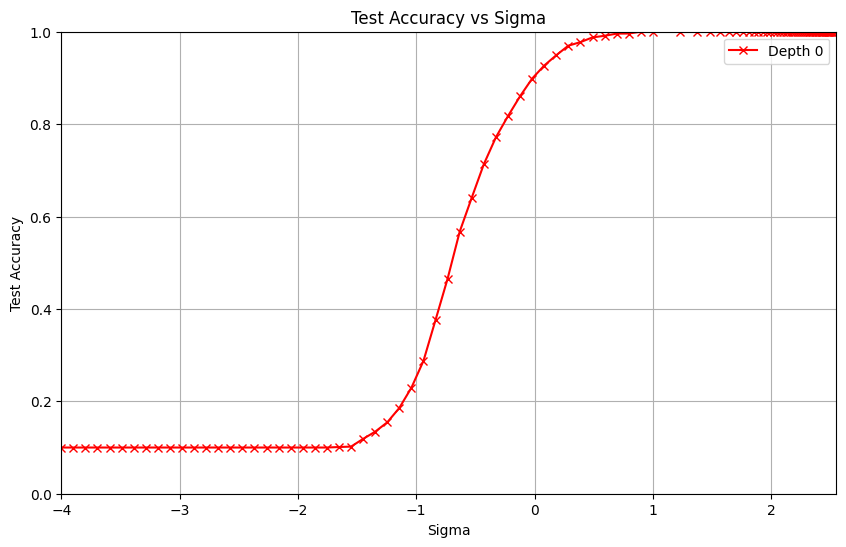

tensor(0.)


In [120]:
# Set up colors for the three depths
colors = ['red', 'blue', 'green']
labels = ['Depth 0', 'Depth 1', 'Depth 2']

# 1. Plot magnetization vs sigma for three depths
plt.figure(figsize=(10,6))
for d in range(len(vec_layers)):
    plt.plot(np.log10(vec_sigma), magnetization[:, d], color=colors[d], label=labels[d],marker='x')
plt.title('Magnetization vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Magnetization')
plt.legend()
plt.grid(True)
plt.xlim(-4,2.55)
plt.show()

# 1. Plot magnetization vs sigma for three depths
plt.figure(figsize=(10,6))
for d in range(len(vec_layers)):
    plt.plot(np.log10(vec_sigma), norm[:, d], color=colors[d], label=labels[d],marker='x')
plt.title('Norm vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Norm')
plt.legend()
plt.grid(True)
plt.xlim(-4,2.55)
plt.show()



# 2. Plot loss_test vs sigma for three depths
plt.figure(figsize=(10,6))
for d in range(len(vec_layers)):
    plt.plot(np.log10(vec_sigma), loss_test[:, d], color=colors[d], label=labels[d],marker='x')
plt.title('Test Loss vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.xlim(-4,2.55)
plt.show()

# 3. Plot accuracy_test vs sigma for three depths
plt.figure(figsize=(10,6))
for d in range(len(vec_layers)):
    plt.plot(np.log10(vec_sigma), accuracy_test[:, d], color=colors[d], label=labels[d],marker='x')
plt.title('Test Accuracy vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Test Accuracy')
plt.legend()
plt.ylim(0,1)
plt.xlim(-4,2.55)
plt.grid(True)
plt.show()


print(distance)





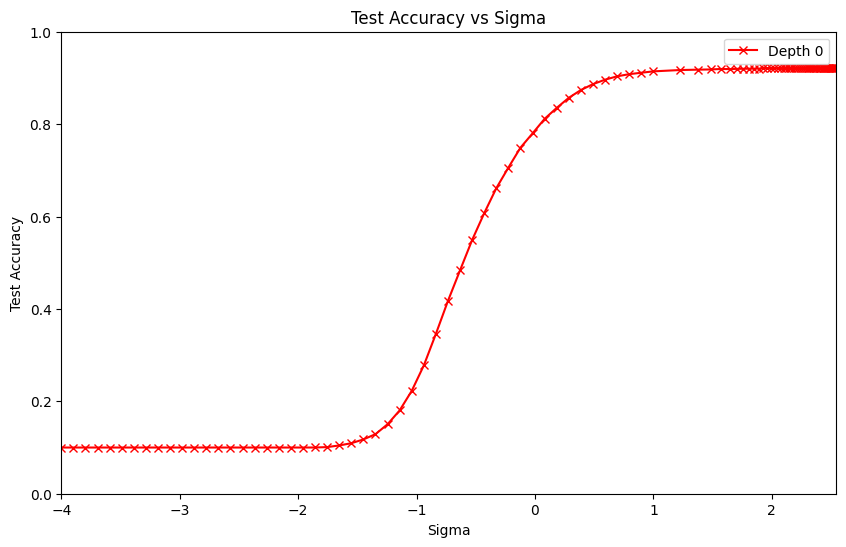

In [31]:
accuracy_proxy = np.zeros((num_sigma))

for s in range(num_sigma):
    accuracy_proxy[s] = np.mean(confusion_matrices[s])

# 3. Plot accuracy_test vs sigma for three depths
plt.figure(figsize=(10,6))
for d in range(len(vec_layers)):
    plt.plot(np.log10(vec_sigma), accuracy_proxy, color=colors[d], label=labels[d],marker='x')
plt.title('Test Accuracy vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Test Accuracy')
plt.legend()
plt.ylim(0,1)
plt.xlim(-4,np.log10(350))
#plt.grid(True)
plt.show()


### SAVE CROSS-ACCURACY MATRICES IN PNG (GIF PURPOSES) 

In [33]:
# Find the maximum value across all confusion matrices
max_value = np.max([np.max(cm) for cm in confusion_matrices])


for d in range(len(vec_layers)):
    for s in range(num_sigma):
        plt.figure(figsize=(6, 6))  # Moved this inside the loop to create a new figure for each matrix
        
        plt.imshow(confusion_matrices[d*num_sigma+s], cmap="bwr", vmin=0, vmax=max_value)
        plt.title(f"$\sigma = {vec_sigma[s]*tau:.5e}$")
        plt.axis('off')

        # Use the simple integer value for s in the filename
        filename = f"confusion_matrix_depth_{vec_layers[d]}_sigma_{s}.png"
        plt.savefig(filename, bbox_inches="tight")
        plt.close()  # Close the current figure to free up memory




In [208]:
accuracy_proxy = np.zeros((num_sigma))

for s in range(num_sigma):
    accuracy_proxy[s] = np.mean(confusion_matrices[s])

def save_arrays(vec_layers, magnetization, norm, accuracy_train, accuracy_test, loss_train, loss_test, couplings, accuracy_proxy):
    #np.savetxt(f"states_{vec_layers[0]}.txt", states)
    np.savetxt(f"magnetization_{vec_layers[0]}.txt", magnetization)
    np.savetxt(f"norm_{vec_layers[0]}.txt", norm)
    np.savetxt(f"accuracy_train_{vec_layers[0]}.txt", accuracy_train)
    np.savetxt(f"accuracy_test_{vec_layers[0]}.txt", accuracy_test)
    np.savetxt(f"loss_train_{vec_layers[0]}.txt", loss_train)
    np.savetxt(f"loss_test_{vec_layers[0]}.txt", loss_test)
    np.savetxt(f"couplings_{vec_layers[0]}.txt", couplings)
    #np.savetxt(f"distance_{vec_layers[0]}.txt", distance)
    # Assuming confusion_matrices is convertible to array
    np.savetxt(f"accuracy_matrix_{vec_layers[0]}.txt", np.array(accuracy_proxy))
    
save_arrays(vec_layers, magnetization, norm, accuracy_train, accuracy_test, loss_train, loss_test, couplings, accuracy_proxy)


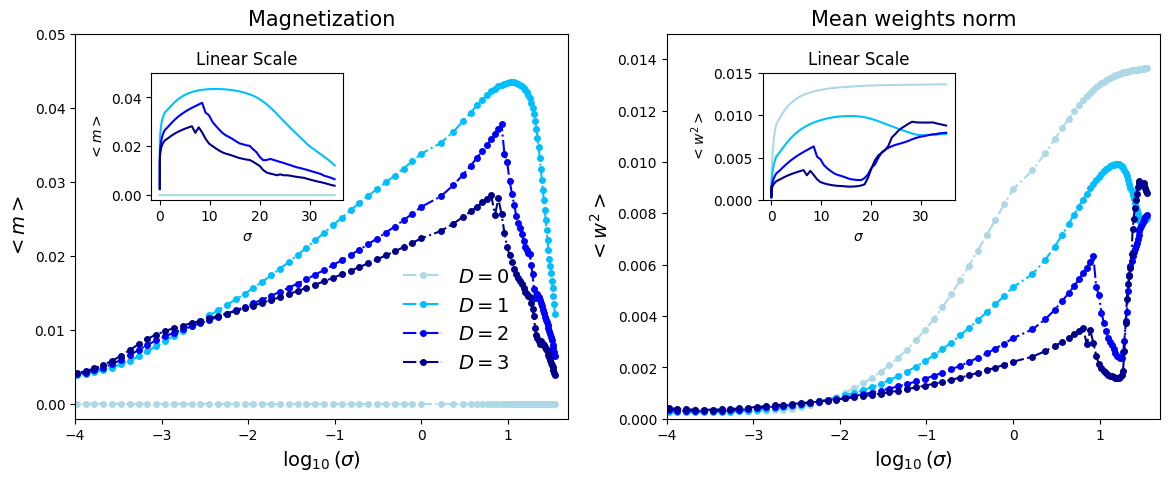

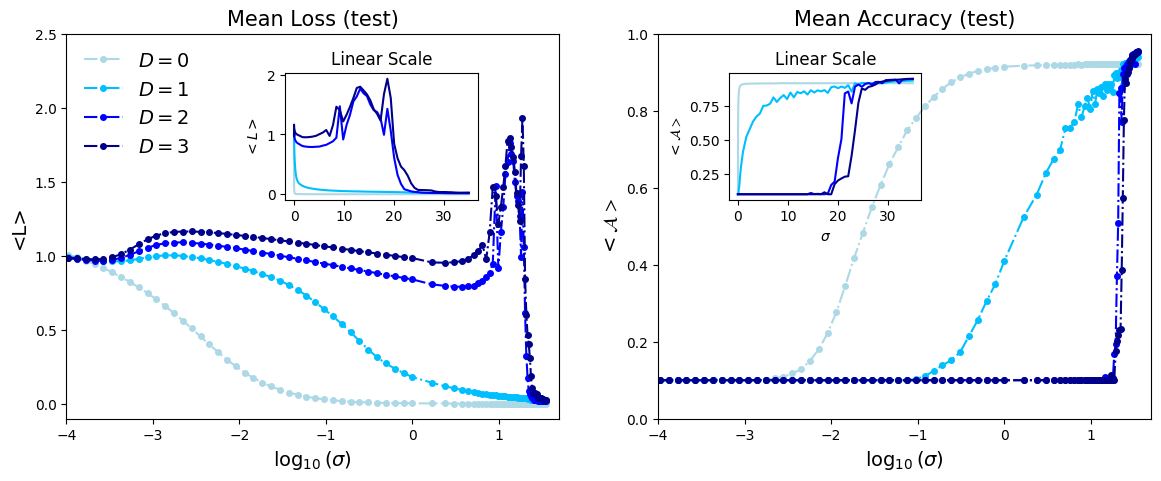

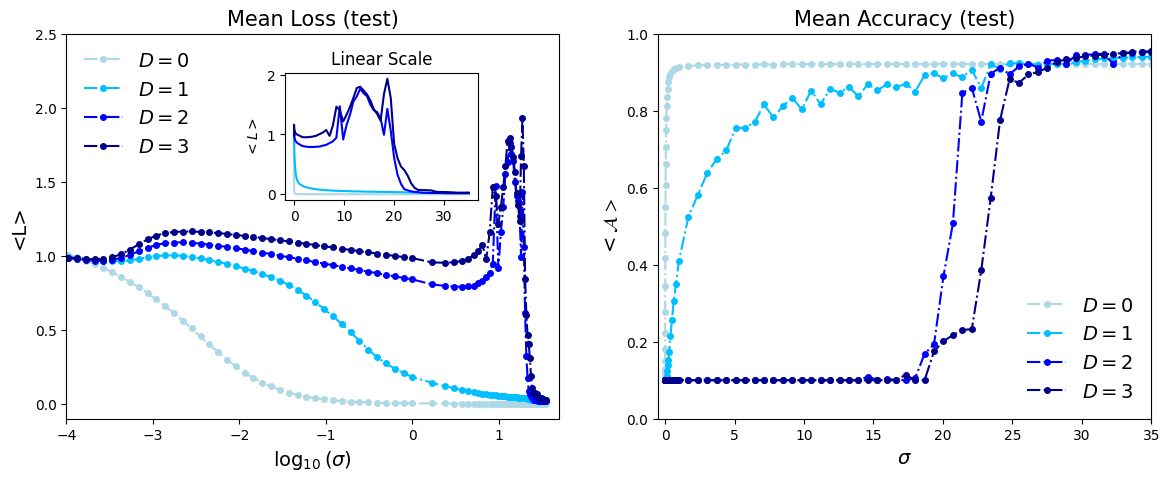

In [400]:
def load_arrays(vec_layer):
    magnetization = np.loadtxt(f"magnetization_{vec_layer}.txt")
    norm = np.loadtxt(f"norm_{vec_layer}.txt")
    accuracy_train = np.loadtxt(f"accuracy_train_{vec_layer}.txt")
    accuracy_test = np.loadtxt(f"accuracy_test_{vec_layer}.txt")
    loss_train = np.loadtxt(f"loss_train_{vec_layer}.txt")
    loss_test = np.loadtxt(f"loss_test_{vec_layer}.txt")
    couplings = np.loadtxt(f"couplings_{vec_layer}.txt")
    accuracy_matrix = np.loadtxt(f"accuracy_matrix_{vec_layer}.txt")
    return magnetization, norm, accuracy_train, accuracy_test, loss_train, loss_test, couplings, accuracy_matrix



# Assuming you've loaded all four depths in variables named states0, states1, states2, states3 etc.
depths = [0, 1, 2, 3]
colors = ['lightblue', 'deepskyblue', 'blue', 'darkblue']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(14, 5))

# Plotting Magnetization and Norm
plt.subplot(1,2, 1)
for i, depth in enumerate(depths):
    plt.plot(np.log10(vec_sigma/num_models),load_arrays(depth)[0], label=f"$D = {depth}$", color=colors[i],marker='.',linestyle='-.',markersize=8)
plt.title("Magnetization",fontsize=15)
plt.xlabel("$\log_{10}(\sigma)$",fontsize=14)
plt.ylabel("$<m>$",fontsize=14)
plt.legend(loc=(0.65,0.1),frameon=False,fontsize=14)
plt.xlim(-4,np.log10(50))
plt.ylim(-0.002,0.05)

# Create the inset with specific position and size
ax = plt.gca()
axins = inset_axes(ax, width="30%", height="30%", 
                   bbox_to_anchor=(0.14, 0.55, 1.3, 1.1),
                   bbox_transform=ax.transAxes,
                   loc=3)  # Location is now set to 3, meaning lower left corner

# Plotting in the inset
for i, depth in enumerate(depths):
    axins.plot(vec_sigma/num_models, load_arrays(depth)[0], label=f"Depth {depth}", color=colors[i])
axins.set_title("Linear Scale")
#axins.set_xlim(-0.1,1.75)
axins.set_ylim(-0.002,0.05)
#axins.set_xlabel("Coupling")
#axins.set_ylabel("Magnetization")
axins.set_xlabel("$\sigma$")
axins.set_ylabel("$<m>$")
axins.set_xticks([0,10,20,30])



plt.subplot(1,2, 2)
for i, depth in enumerate(depths):
    plt.plot(np.log10(vec_sigma/num_models),load_arrays(depth)[1], label=f"Depth {depth}", color=colors[i],marker='.',linestyle='-.',markersize=8)
plt.title("Mean weights norm",fontsize=15)
plt.xlabel("$\log_{10}(\sigma)$",fontsize=14)
plt.ylabel("$<w^2>$",fontsize=14)
#plt.legend()
plt.xlim(-4,np.log10(50))
plt.ylim(0,0.015)

# Create the inset with specific position and size
ax = plt.gca()
axins = inset_axes(ax, width="30%", height="30%", 
                   bbox_to_anchor=(0.18, 0.55, 1.3, 1.1),
                   bbox_transform=ax.transAxes,
                   loc=3)  # Location is now set to 3, meaning lower left corner

# Plotting in the inset
for i, depth in enumerate(depths):
    axins.plot(vec_sigma/num_models, load_arrays(depth)[1], label=f"Depth {depth}", color=colors[i])
axins.set_title("Linear Scale")
#axins.set_xlim(-0.1,1.75)
axins.set_ylim(0,0.015)
axins.set_xlabel("$\sigma$")
axins.set_ylabel("$<w^2>$")
axins.set_xticks([0,10,20,30])







plt.figure(figsize=(14, 5))

# Plotting Test Loss and Test Accuracy
plt.subplot(1,2, 1)
for i, depth in enumerate(depths):
    loss_plots = load_arrays(depth)[5]
    plt.plot(np.log10(vec_sigma/num_models),load_arrays(depth)[5]/loss_plots[0], label=f"$D = {depth}$", color=colors[i],marker='.',linestyle='-.',markersize=8)
plt.title("Mean Loss (test)",fontsize=15)
plt.xlabel("$\log_{10}(\sigma)$",fontsize=14)
plt.ylabel("<L>",fontsize=14)
plt.xlim(-4,np.log10(50))
plt.ylim(-0.1,2.5)
plt.legend(frameon=False,fontsize=14)

# Create the inset with specific position and size
ax = plt.gca()
axins = inset_axes(ax, width="30%", height="30%", 
                   bbox_to_anchor=(0.43, 0.55, 1.3, 1.1),
                   bbox_transform=ax.transAxes,
                   loc=3)  # Location is now set to 3, meaning lower left corner

# Plotting in the inset
for i, depth in enumerate(depths):
    loss_plots = load_arrays(depth)[5]
    axins.plot(vec_sigma/num_models, load_arrays(depth)[5]/loss_plots[0], label=f"Depth {depth}", color=colors[i])
axins.set_title("Linear Scale")
#axins.set_xlim(-0.1,1.75)
#axins.set_ylim(0,0.015)
#axins.set_xlabel("$\sigma$")
axins.set_ylabel("$<L>$")
axins.set_xticks([0,10,20,30])




plt.subplot(1,2, 2)
for i, depth in enumerate(depths):
    plt.plot(np.log10(vec_sigma/num_models),load_arrays(depth)[7], label=f"Depth {depth}", color=colors[i],marker='.',linestyle='-.',markersize=8)
plt.title("Mean Accuracy (test)",fontsize=15)
plt.xlabel("$\log_{10}(\sigma)$",fontsize=14)
plt.ylabel("$<\cal{A}>$",fontsize=14)
#plt.legend()
plt.xlim(-4,np.log10(50))
plt.ylim(0,1)



# Create the inset with specific position and size
ax = plt.gca()
axins = inset_axes(ax, width="30%", height="30%", 
                   bbox_to_anchor=(0.13, 0.55, 1.3, 1.1),
                   bbox_transform=ax.transAxes,
                   loc=3)  # Location is now set to 3, meaning lower left corner

# Plotting in the inset
for i, depth in enumerate(depths):
    axins.plot(vec_sigma/num_models, load_arrays(depth)[7], label=f"Depth {depth}", color=colors[i])
axins.set_title("Linear Scale")
#axins.set_xlim(-0.1,1.75)
#axins.set_ylim(0,0.015)
axins.set_xlabel("$\sigma$")
axins.set_ylabel("$<\cal{A}>$")
axins.set_xticks([0,10,20,30])

axins.patch.set_facecolor('none')  # This line makes the background transparent
axins.patch.set_edgecolor('black') # Optional, adds a border to the inset



plt.show()



plt.figure(figsize=(14, 5))

# Plotting Test Loss and Test Accuracy
plt.subplot(1,2, 1)
for i, depth in enumerate(depths):
    loss_plots = load_arrays(depth)[5]
    plt.plot(np.log10(vec_sigma/num_models),load_arrays(depth)[5]/loss_plots[0], label=f"$D = {depth}$", color=colors[i],marker='.',linestyle='-.',markersize=8)
plt.title("Mean Loss (test)",fontsize=15)
plt.xlabel("$\log_{10}(\sigma)$",fontsize=14)
plt.ylabel("<L>",fontsize=14)
plt.xlim(-4,np.log10(50))
plt.ylim(-0.1,2.5)
plt.legend(frameon=False,fontsize=14)

# Create the inset with specific position and size
ax = plt.gca()
axins = inset_axes(ax, width="30%", height="30%", 
                   bbox_to_anchor=(0.43, 0.55, 1.3, 1.1),
                   bbox_transform=ax.transAxes,
                   loc=3)  # Location is now set to 3, meaning lower left corner

# Plotting in the inset
for i, depth in enumerate(depths):
    loss_plots = load_arrays(depth)[5]
    axins.plot(vec_sigma/num_models, load_arrays(depth)[5]/loss_plots[0], label=f"Depth {depth}", color=colors[i])
axins.set_title("Linear Scale")
#axins.set_xlim(-0.1,1.75)
#axins.set_ylim(0,0.015)
#axins.set_xlabel("$\sigma$")
axins.set_ylabel("$<L>$")
axins.set_xticks([0,10,20,30])




plt.subplot(1,2, 2)
for i, depth in enumerate(depths):
    plt.plot((vec_sigma/num_models),load_arrays(depth)[7], label=f"$D = {depth}$", color=colors[i],marker='.',linestyle='-.',markersize=8)
plt.title("Mean Accuracy (test)",fontsize=15)
plt.xlabel("$\sigma$",fontsize=14)
plt.ylabel("$<\cal{A}>$",fontsize=14)
#plt.legend()
plt.xlim(-0.5,35)
plt.ylim(0,1)
plt.legend(frameon=False,fontsize=14)


# Create the inset with specific position and size
#ax = plt.gca()
#axins = inset_axes(ax, width="30%", height="30%", 
#                   bbox_to_anchor=(0.13, 0.55, 1.3, 1.1),
#                   bbox_transform=ax.transAxes,
#                   loc=3)  # Location is now set to 3, meaning lower left corner

# Plotting in the inset
#for i, depth in enumerate(depths):
#    axins.plot(vec_sigma/num_models, load_arrays(depth)[7], label=f"Depth {depth}", color=colors[i])
#axins.set_title("Linear Scale")
#axins.set_xlim(-0.1,1.75)
#axins.set_ylim(0,0.015)
#axins.set_xlabel("$\sigma$")
#axins.set_ylabel("$<\cal{A}>$")
#axins.set_xticks([0,10,20,30])

#axins.patch.set_facecolor('none')  # This line makes the background transparent
#axins.patch.set_edgecolor('black') # Optional, adds a border to the inset



plt.show()




